In [1]:
################################# 1. Load model and visual the generated images #################################
import torch
import numpy as np
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler
from generative.inferers import DiffusionInferer
import matplotlib.pyplot as plt

C:\Users\nkvhu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\nkvhu\AppData\Roaming\Python\Python312\site-packages\generative\networks\layers\vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
C:\Users\nkvhu\AppData\Roaming\Python\Python312\site-packages\generative\networks\layers\vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
# settings
unet_ckpt = './ddpm-last.pth'  # You can load your own 3D convolutional model
device = torch.device('cuda')
ddpm_steps = 1000
img_size = (1, 1, 160, 224, 160)

In [3]:
# model (pretained on UKB)
diffusion_unet = DiffusionModelUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        num_res_blocks=2,
        num_channels=(32, 32, 64, 128, 256, 512),
        attention_levels=(False, False, False, False, True, True),
        norm_num_groups=32,
        norm_eps=1e-6,
        num_head_channels=(0, 0, 0, 0, 256, 512)
    )
diffusion_unet.load_state_dict(torch.load(unet_ckpt))
diffusion_unet.to(device)
raw_params = sum(p.numel() for p in diffusion_unet.parameters() if p.requires_grad)

In [4]:
# Scheduler and Inferer
scheduler = DDPMScheduler(
    num_train_timesteps=ddpm_steps,
    schedule='scaled_linear_beta',
    beta_start=0.0005,
    beta_end=0.0195,
)
inferer = DiffusionInferer(scheduler)

In [5]:
# Generate MRI images
noise = torch.randn(img_size).to(device)
synt = inferer.sample(
    input_noise=noise, diffusion_model=diffusion_unet, scheduler=inferer.scheduler
)
synt = synt[0][0]
print(f'Generate MRI scan shaped {synt.shape}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:56<00:00,  2.80it/s]

Generate MRI scan shaped torch.Size([160, 224, 160])


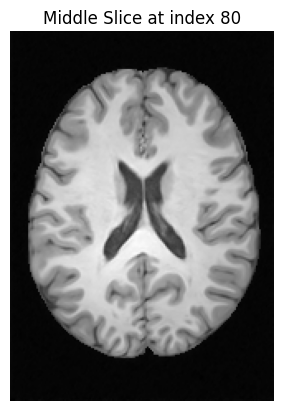

In [6]:
# Visualize synt
middle_index = synt.shape[-1] // 2
slice_image = synt[:, :, middle_index]
plt.imshow(np.rot90(slice_image.cpu().numpy()), cmap='gray')
plt.title(f"Middle Slice at index {middle_index}")
plt.axis('off')
plt.show()

In [7]:
################################# 2. Load the BraTS dataset, wrap UNet with TenVOO, and perform fine-tuning #################################

import os
import glob
import torch
import torch.nn.functional as F
from monai import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from peft import TenVOOConfig, TenVOOModel, TENVOO_LIST, LoConConfig, LoConModel
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

In [8]:
# data
def brats_transform(spatial_size=(192, 192, 144), scale_ratio=1.5, minv=0, maxv=1):
    return transforms.Compose([
        transforms.EnsureChannelFirst(),
        transforms.ResizeWithPadOrCrop(spatial_size=spatial_size, mode='minimum'),
        transforms.Orientation(axcodes='RAS'),
        transforms.Spacing(pixdim=scale_ratio),
        transforms.ScaleIntensity(minv=minv, maxv=maxv)
    ])
    
class DDPMDataset(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        if isinstance(root, list):
            self.input_list = root
        else:
            self.input_list = glob.glob(root)
        self.transform = transform
        self.loader = transforms.LoadImage(image_only=True)

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self, item):
        x = self.loader(self.input_list[item])
        if self.transform is not None:
            try:
                x = self.transform(x)
            except Exception as e:
                print(f"Transform failed at index {item}: {e}")
                raise
        return x

brats_root = 'F:/data/BraTS2021/'
# filter
with open(os.path.join(brats_root, 'clean_brats.txt'), 'r', encoding='utf-8') as fr:
    clean_files = [f.strip() for f in fr.readlines()]
brats_files = [r for r in glob.glob(os.path.join(brats_root, '*', '*', '*t1.nii.gz')) if r.replace('\\', '/').split('/')[-1] in clean_files]
dataset = DDPMDataset(root=brats_files, transform=brats_transform())
print(f'Load {len(dataset)} MRI scans from the root, each shaped {dataset[0][0].shape}')


Load 327 MRI scans from the root, each shaped torch.Size([128, 128, 96])


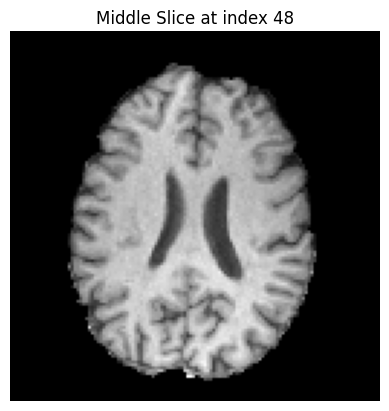

In [9]:
# Visualize one image from brats
brats_image = dataset[0][0]
middle_index = brats_image.shape[-1] // 2
slice_image = brats_image[:, :, middle_index]
plt.imshow(np.rot90(slice_image.cpu().numpy()), cmap='gray')
plt.title(f"Middle Slice at index {middle_index}")
plt.axis('off')
plt.show()

In [10]:
# model: tenvoo-l
DDPM_LAYERS = {
    "conv1": ".*resnets.*.conv1.conv",
    "conv2": ".*resnets.*.conv2.conv",
    "to_q": ".*attentions.*.to_q",
    "to_v": ".*attentions.*.to_v",
    "time_emb": "time_embed.2",
    "time_proj": ".*resnets.*.time_emb_proj",
    # not used in our work
    "attn_proj": ".*attentions.*.*.attn_proj",
    "to_k": ".*attentions.*.to_k",
    "skip": ".*resnets.*.skip_connection.conv",
    "ds": ".*downsampler.op.conv",
    "us": ".*upsampler.conv.conv",
}
target_modules = [DDPM_LAYERS[t] for t in ['conv1', 'conv2', 'to_q', 'to_v', 'time_emb', 'time_proj']]
print(target_modules)


['.*resnets.*.conv1.conv', '.*resnets.*.conv2.conv', '.*attentions.*.to_q', '.*attentions.*.to_v', 'time_embed.2', '.*resnets.*.time_emb_proj']


In [11]:
# as spatial dimension changes, we use r=12 here
config = TenVOOConfig(d_in=3, d_out=3, per_dim_list=TENVOO_LIST, target_modules=target_modules, model_mode='l', rank=12)
diffusion_unet = TenVOOModel(config, diffusion_unet).to(device)

# # Lora / Locon can be used for comparison
# config = LoConConfig(target_modules=target_modules, rank=4, alpha=0.0)
# diffusion_unet = LoConModel(config, diffusion_unet).to(device)

print("Low-rank layers and their names:")
for n, p in diffusion_unet.named_parameters():
    if p.requires_grad:
        print(n)
train_params = sum(p.numel() for p in diffusion_unet.parameters() if p.requires_grad)
print(f"Use {train_params / 1000 ** 2}M / {raw_params / 1000 ** 2}M for fine-tuning")

The settings of your model are:
 TenVOOConfig(peft_type=<PeftType.TENVOO: 'TENVOO'>, base_model_name_or_path=None, task_type=None, inference_mode=False, target_modules=['.*resnets.*.conv1.conv', '.*resnets.*.conv2.conv', '.*attentions.*.to_q', '.*attentions.*.to_v', 'time_embed.2', '.*resnets.*.time_emb_proj'], rank=12, bias='lora_only', requires_full_weights_grad=False, exclude_first_last_conv=True, d_in=3, d_out=3, per_dim_list={32: [4, 4, 2], 64: [8, 4, 2], 128: [8, 8, 2], 256: [8, 8, 4], 512: [16, 8, 4], 1024: [16, 16, 4], 768: [16, 8, 6], 384: [8, 8, 6], 192: [8, 6, 4], 96: [8, 4, 3], 1: [1, 1, 1], 2: [2, 1, 1], 4: [2, 2, 1], 8: [2, 2, 2], 16: [4, 2, 2], 48: [8, 3, 2], 24: [4, 3, 2], 12: [4, 3, 1], 6: [3, 2, 1]}, dropout=0.0, merge_weights=True, sum_mode=False, initialize_mode='sum_opposite_freeze_one', model_mode='l')
Low-rank layers and their names:
model.time_embed.2.bias
model.time_embed.2.quanta_weights.-1 -2
model.time_embed.2.quanta_weights.-1 -3
model.time_embed.2.quanta_w

In [12]:
# training
accu_steps = 4
batch_size = 1
epochs = 10
trainset, _ = random_split(dataset, [len(dataset), 0])
train_loader = DataLoader(dataset=trainset, num_workers=0, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(diffusion_unet.parameters(), lr=5e-5)
scaler = GradScaler(enabled=True)

for epoch in range(epochs):
    epoch_loss = 0
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    train_bar.set_description(f"Epoch {epoch}")
    for step, imgs in train_bar:
        diffusion_unet.train()
        # train
        imgs = imgs.to(device)
        imgs = imgs.as_tensor()
        with autocast(enabled=True, dtype=torch.float16):
            noise = torch.randn_like(imgs).to(device)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (imgs.shape[0],), device=imgs.device
            ).long()
            target = noise
            noise_pred = inferer(
                inputs=imgs, diffusion_model=diffusion_unet, noise=noise, timesteps=timesteps
            )
            loss = F.mse_loss(noise_pred.float(), target.float())
        scaler.scale(loss).backward()
        if (step + 1) % accu_steps == 0 or (step + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
        epoch_loss += loss.item()
        train_bar.set_postfix({'loss': epoch_loss / (step + 1)})


C:\Users\nkvhu\AppData\Local\Temp\ipykernel_73240\2613767420.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
Epoch 0:   0%|                                | 0/327 [00:00<?, ?it/s]C:\Users\nkvhu\AppData\Local\Temp\ipykernel_73240\2613767420.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True, dtype=torch.float16):
Epoch 9: 100%|████████| 327/327 [04:02<00:00,  1.35it/s, loss=0.00301]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.86it/s]


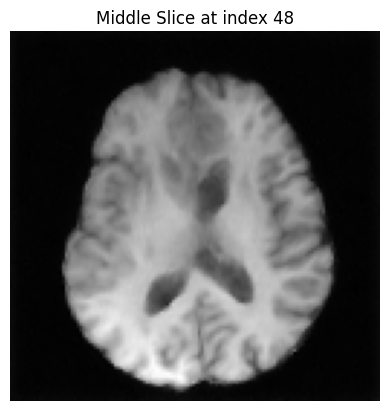

Generate MRI scan shaped torch.Size([128, 128, 96])


In [13]:
################################# 3. Visual the generated images with the fine-tuned model #################################
img_size = (1, 1, 128, 128, 96)  # different spatial dimension for brats
# Generate MRI images
diffusion_unet.eval()
noise = torch.randn(img_size).to(device)
synt = inferer.sample(
    input_noise=noise, diffusion_model=diffusion_unet, scheduler=inferer.scheduler
)
synt = synt[0][0]
# Visualize one image from brats
brats_image = synt
middle_index = brats_image.shape[-1] // 2
slice_image = brats_image[:, :, middle_index]
plt.imshow(np.rot90(slice_image.cpu().numpy()), cmap='gray')
plt.title(f"Middle Slice at index {middle_index}")
plt.axis('off')
plt.show()
print(f'Generate MRI scan shaped {synt.shape}')

In [14]:
################################# 4. (Optional) Save only the TenVOO weights #################################
state_dict = {
    name: param.cpu() for name, param in diffusion_unet.state_dict().items() 
    if 'tenvoo' in name
}
torch.save(state_dict, 'tenvoo_weights.pth')
